In [12]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.swin_transformer as swin

#from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import random

#import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

from tqdm import tqdm

#import json

import wandb

import kornia

from torch_trainer import torch_trainer
import data
from hr2lr import hr2lr

%matplotlib inline

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class Config(dict):
    def __init__(self):
        super().__init__(
            dict(
                #input_path = "/kaggle/input/stanford-cars-dataset",
                #output_path = "/kaggle/working",
                #checkpoint_path = "mbr.pt",
                epochs = 100, 
                input_size = (3,64,64),
                hidden_dim=180,
                patch_size=4,
                num_heads=4,
                window_size=7,
                upsample = 2,
                #cpu_count = mp.cpu_count(),
                #gpu_count = torch.cuda.device_count() if torch.cuda.is_available() else 0,
                device = "cuda" if torch.cuda.is_available() else "cpu",
                num_workers=2,
                batch_size=1,
                #dist_enabled = True,
                #dist_worldsize = os.environ["DIST_WORLDSIZE"] if "DIST_WORLDSIZE" in os.environ else (torch.cuda.device_count() if torch.cuda.is_available() else 1), 
                #dist_port = os.environ["DIST_PORT"] if "DIST_PORT" in os.environ else 23456,
                #dist_hostname = os.environ["DIST_HOSTNAME"] if "DIST_HOSTNAME" in os.environ else "localhost",
                #rank = dist.get_rank() if dist.is_initialized() else None,
                #localrank = dist.get_rank() % torch.cuda.device_count() if (torch.cuda.is_available() and dist.is_initialized()) else 0
            )) 

In [9]:
class PatchUnembed(nn.Module):
    def forward(self, x):
        #print ('unemb ', x.shape)
        return x.permute(0,3,1,2)

class PatchEmbed(nn.Module):
    def forward(self, x):
        #print ('emb ', x.shape)
        return x.permute(0,2,3,1)


class RSTB(nn.Sequential):
    def __init__(self, config, sdp):
        super().__init__(
                *[swin.SwinTransformerBlockV2(
                    dim=config["hidden_dim"], num_heads=4, window_size=[config["window_size"]]*2,
                    shift_size=[0,0] if (i%2==0) else [config["window_size"]//2]*2,
                    stochastic_depth_prob=sdp[i]) for i in range(6)],
                PatchUnembed(),
                nn.Conv2d(config["hidden_dim"], config["hidden_dim"]//4, 3, padding=1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(config["hidden_dim"]//4, config["hidden_dim"]//4, 1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(config["hidden_dim"]//4, config["hidden_dim"],3,padding=1),
                PatchEmbed(),
        )


class SwinIR(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        
        
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bicubic'),
        )
        self.embed = nn.Sequential(
            nn.Conv2d(config["input_size"][0],config["hidden_dim"], 3, padding=1),
            PatchEmbed()
        )
        sdp = [v.item() for v in torch.linspace(0,0.2,36)]
        self.rstb_layers = nn.ModuleList(
            [RSTB(config, sdp[i*6:(i+1)*6]) for i in range(6)]
        )
        self.unembed = nn.Sequential(
            PatchUnembed(),
            nn.Conv2d(config["hidden_dim"],config["hidden_dim"]//4,3,padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(config["hidden_dim"]//4,config["hidden_dim"]//4,1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            #nn.Conv2d(config["hidden_dim"]//4, config["hidden_dim"], 3, padding=1),

            #nn.Conv2d(config["hidden_dim"], config["hidden_dim"], 3, padding=1),
            #nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #nn.Conv2d(config['hidden_dim'], config["hidden_dim"]*4, 3, padding=1),
            #nn.PixelShuffle(2),
            #nn.Conv2d(config["hidden_dim"], config["hidden_dim"], 3, padding=1),
            #nn.LeakyReLU(negative_slope=0.2, inplace=True),

            #nn.Conv2d(config["hidden_dim"], config["hidden_dim"]*4, 3, padding=1),
            #nn.PixelShuffle(2),
            #nn.Conv2d(config["hidden_dim"], config["hidden_dim"], 3, padding=1),
            #nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(config["hidden_dim"]//4, config["input_size"][0], 3, padding=1)
        )


    def forward(self, x):
        x_source = x
        #print('---', x.shape)
        x = self.upscale(x)
        y = self.embed(x)
        y0 = y
        for rstb in self.rstb_layers:
            y = rstb(y) + y
        y = y + y0
        #print(y.shape)
        return x_source, self.unembed(y) + x

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


# patches

In [16]:
ds_lr_patches = data.data_patches_realsr_x2_train(patch_size=(64,64), limit=1, refastarget=True)
ds_train_patches, ds_val_patches = torch.utils.data.random_split(ds_lr_patches, [0.85, 0.15])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


In [7]:
#ds_lr_patches.images_source_patches[0].shape, ds_lr_patches.images_target_patches[0].shape

In [17]:
BATCH_SIZE = 1

dl_train_patches = DataLoader(ds_train_patches, batch_size=BATCH_SIZE, shuffle=True)
dl_val_patches = DataLoader(ds_val_patches, batch_size=1, shuffle=False)
dl_lr_patches = {'train': dl_train_patches, 'test': dl_val_patches}

In [18]:
scale = 2

kernel = torch.tensor(
        [
            [
                [0.1, 1.0, 4.0, 6.0, 4.0, 1.0, 0.1],
                [1.0, 4.0, 16.0, 24.0, 16.0, 4.0, 1.0],
                [4.0, 6.0, 24.0, 36.0, 24.0, 6.0, 4.0],
                [1.0, 4.0, 16.0, 24.0, 16.0, 4.0, 1.0],
                [0.1, 1.0, 4.0, 6.0, 4.0, 1.0, 0.1],
            ]
        ]
    )/ 256.0

kernel = kernel.to(device)
noise = (0.0, 0.015)

def loss_ssim_l2(y_pred, y_true, eps=1e-2):
    y_source, y_model = y_pred

    y_pred_down = hr2lr(img=y_model, kernel=kernel, noise=noise, factor=scale)
    loss_ssim = kornia.losses.ssim_loss(y_pred_down, y_source, window_size=11, max_val=1.)
    loss_l2 = nn.MSELoss()(y_pred_down, y_source)
    loss_tv = kornia.losses.total_variation(y_model, reduction='mean').sum()
    del y_true
    del y_pred_down
    del y_pred
    return loss_l2 + loss_ssim #+ 0.001/loss_tv


def metric_ssim(y_pred, y_true):
    _, y_model = y_pred
    #y_pred_down = hr2lr(img=y_model, kernel=kernel, noise=noise, factor=scale)
    try:
        torchvision.utils.save_image(y_model[0], './run/v3_pred.png')
    except:
        pass
    return kornia.metrics.ssim(y_model, y_true, window_size=11, max_val=1.).mean()

torch.cuda.empty_cache()
config = Config()
model = SwinIR(config)
print(model)
criterion = loss_ssim_l2
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       scheduler=scheduler, 
                       epochs=40,
                       dataloader=dl_lr_patches)
trainer.set_metrics(metric_name='SSIM', metric_function=metric_ssim)
#trainer.wandb_log(True)

#run = wandb.init(project='itmo blind superresolution', 
#                 group='v2_realsr_zssr', 
#                 job_type='train')
#wandb.watch(model, criterion, log="all", log_freq=10)

history = trainer.train()

SwinIR(
  (upscale): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bicubic')
  )
  (embed): Sequential(
    (0): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PatchEmbed()
  )
  (rstb_layers): ModuleList(
    (0): RSTB(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=180, out_features=540, bias=True)
          (proj): Linear(in_features=180, out_features=180, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=180, out_features=720, bias=True)
      

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacty of 12.00 GiB of which 0 bytes is free. Of the allocated memory 10.66 GiB is allocated by PyTorch, and 643.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
int(258//1.5)

172

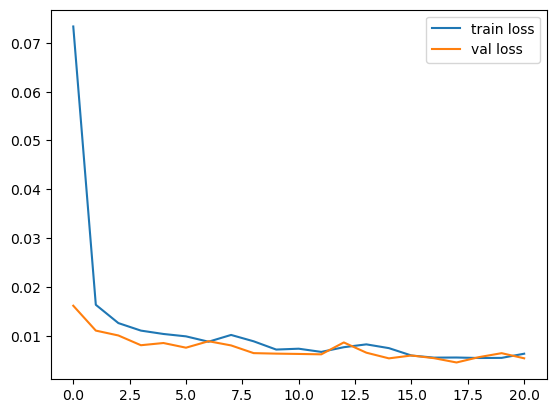

In [10]:
trainer.history.plot()

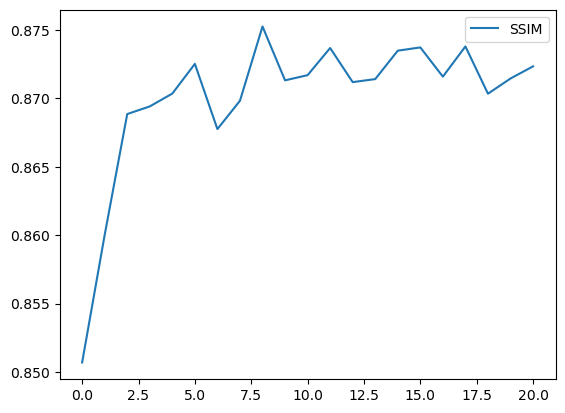

In [11]:
trainer.history.plot(train=False, val=False, metric='SSIM')

In [14]:
def plot_results(img_lr, img_reconstructed, img_gt):
    img_lr_resized = kornia.geometry.resize(img_lr, (img_reconstructed.shape[1],
                                                     img_reconstructed.shape[2]), interpolation='bicubic', antialias=True)
    ssim_lr = kornia.metrics.ssim(img1=img_lr_resized[None,:], img2=img_gt[None,:], window_size=11).mean()
    ssim_reconstructed = kornia.metrics.ssim(img_reconstructed[None,:], img_gt[None,:], window_size=11).mean()
    plt.subplots(1,3, figsize=(15,10))
    plt.subplot(1,3,1)
    plt.imshow(img_gt.permute(1,2,0))
    plt.title(f'hr ground true')
    plt.subplot(1,3,2)
    plt.imshow(img_lr_resized.permute(1,2,0))
    plt.title(f'bicubic, SSIM={ssim_lr:.4f}')
    plt.subplot(1,3,3)
    plt.imshow(img_reconstructed.permute(1,2,0))
    plt.title(f'reconstructed, SSIM={ssim_reconstructed:.4f}')

In [ ]:
torch.save(model.state_dict(), 'cnn_256_11blocks_128_v3_rescon_ssim_l2_tv1_noise0015_epochs40_realsr_kernel7x7.pt')

In [ ]:
#model = sr_from_lr(scale=2, n_blocks=5, channels=128).to(device)
#model.load_state_dict(torch.load('cnn_256_11blocks_128_60ep_08ssim_01l2_01tv_noise0015_div2k.pt'))
#model.eval()
#print(model)

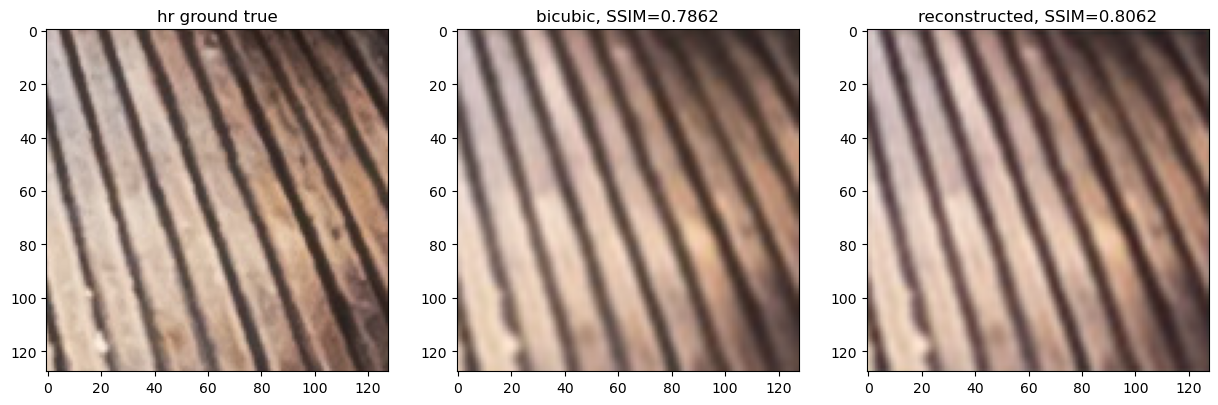

In [15]:
n = 55
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_lr_patches.images_source_patches[n]
img_ref = ds_lr_patches.images_ref_patches[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[1][0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_out.png')
torchvision.utils.save_image(img_ref, 'v3_ref.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


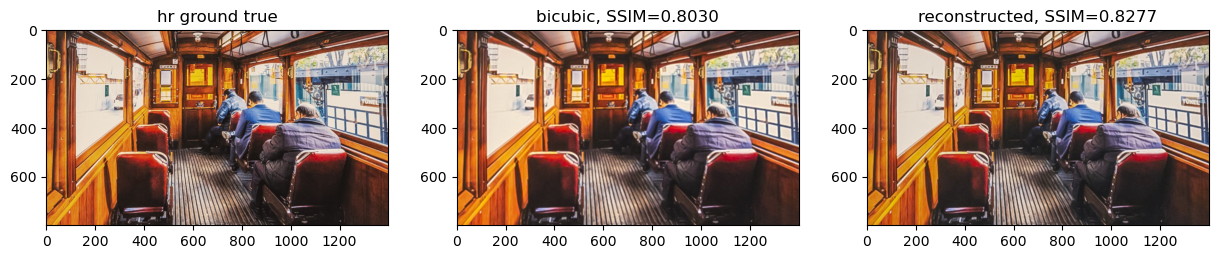

In [14]:
n = 0
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_lr_patches.images_source_img[n]
img_ref = ds_lr_patches.images_ref_img[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[1][0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_full_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_full_out.png')
torchvision.utils.save_image(img_ref, 'v3_full_ref.png')

In [ ]:
n = 459
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_lr_patches.images_source_img[n]
img_ref = ds_lr_patches.images_ref_img[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[1][0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_di2k_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_div2k_out.png')
torchvision.utils.save_image(img_ref, 'v3_div2k_ref.png')

In [15]:
ds_set5 = data.data_set5_x2()
ds_urban100 = data.data_urban100_x2()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.55it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


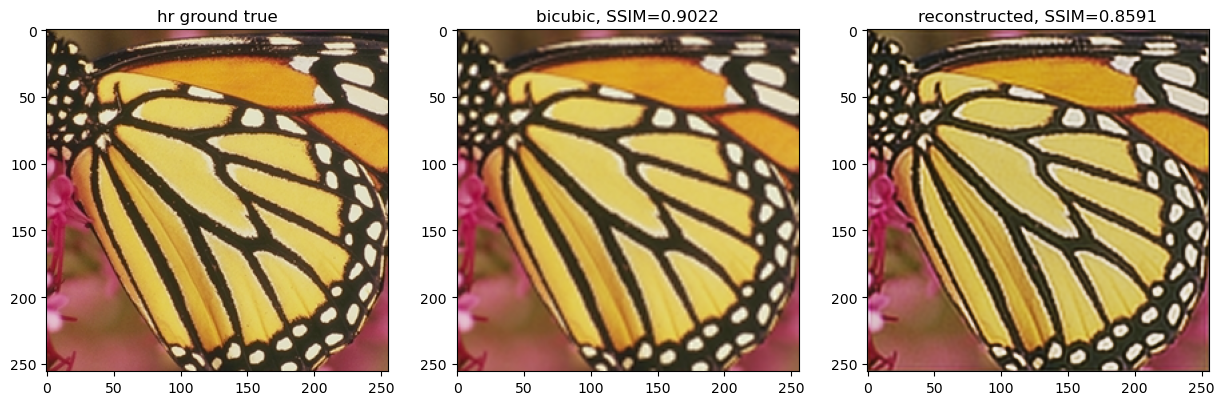

In [16]:
n = 2
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_set5.images_source_img[n]
img_ref = ds_set5.images_ref_img[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[1][0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_set5_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_set5_out.png')
torchvision.utils.save_image(img_ref, 'v3_set_ref.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


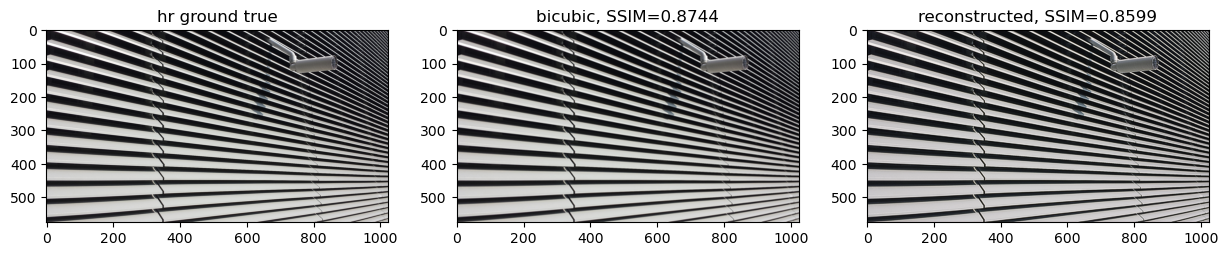

In [17]:
n = 39 #62
torch.cuda.empty_cache()
device_ = 'cuda'
img_lr = ds_urban100.images_source_img[n]
img_ref = ds_urban100.images_ref_img[n]
model.eval()
with torch.no_grad():
    model = model.to(device_)
    img_reconstructed = model(img_lr[None,:].to(device_))[1][0].detach().cpu()
plot_results(img_lr, img_reconstructed, img_ref)
torchvision.utils.save_image(img_lr, 'v3_urban100_in.png')
torchvision.utils.save_image(img_reconstructed, 'v3_urban100_out.png')
torchvision.utils.save_image(img_ref, 'v3_urban100_ref.png')

In [20]:
def calc_mean_results(ds, model, device):
    results = []
    model.eval()
    with torch.no_grad():
        for i in range(ds.__len__()):
            torch.cuda.empty_cache()
            img_lr = ds.images_source_img[i].to(device)
            img_gt = ds.images_ref_img[i].to(device)
            img_reconstructed = model(img_lr[None,:])
            img_lr_resized = kornia.geometry.resize(img_lr, (img_reconstructed.shape[2],
                                                             img_reconstructed.shape[3]), interpolation='bicubic', antialias=True)
            del img_lr
            if img_reconstructed[0].size()==img_gt.size():
                ssim_lr = kornia.metrics.ssim(img1=img_lr_resized[None,:], img2=img_gt[None,:], window_size=11).mean()
                ssim_reconstructed = kornia.metrics.ssim(img_reconstructed, img_gt[None,:], window_size=11).mean()
                del img_reconstructed
                del img_lr_resized
                results.append([ssim_lr, ssim_reconstructed])
        results = torch.tensor(results)
        results_mean = results.mean(dim=0)
    return results_mean, results

In [21]:
res = calc_mean_results(ds_urban100, model, device)
res

(tensor([0.8234, 0.8196]),
 tensor([[0.8107, 0.8077],
         [0.8611, 0.8592],
         [0.9412, 0.8831],
         [0.7147, 0.7094],
         [0.7971, 0.7948],
         [0.8512, 0.8337],
         [0.7409, 0.7519],
         [0.9139, 0.8835],
         [0.8190, 0.8172],
         [0.8660, 0.8671],
         [0.9321, 0.9045],
         [0.7510, 0.7707],
         [0.6911, 0.6934],
         [0.9027, 0.9037],
         [0.8503, 0.8485],
         [0.9127, 0.9052],
         [0.9044, 0.9098],
         [0.7395, 0.7412],
         [0.7654, 0.7697],
         [0.8744, 0.8857],
         [0.8090, 0.8077],
         [0.8435, 0.8496],
         [0.8272, 0.8235],
         [0.8145, 0.8240],
         [0.7432, 0.7579],
         [0.9177, 0.9100],
         [0.8385, 0.8411],
         [0.9038, 0.8978],
         [0.6826, 0.6935],
         [0.8529, 0.8360],
         [0.6450, 0.6506],
         [0.7628, 0.7701],
         [0.8806, 0.8693],
         [0.9173, 0.8799],
         [0.7476, 0.7619],
         [0.8690, 0.8707],
 

In [50]:
res = calc_mean_results(ds_set5, model, device)
res

(tensor([0.9125, 0.9020]),
 tensor([[0.9463, 0.9422],
         [0.9657, 0.9415],
         [0.9022, 0.8917],
         [0.8035, 0.7979],
         [0.9448, 0.9365]]))

In [21]:
ds_div2k = data.data_patches_div2k_bicubic_x2_train()

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 786/800 [00:31<00:00, 25.26it/s]


In [ ]:
res = calc_mean_results(ds_div2k, model, device)
res

In [6]:
x1 = 1
x2 = 2
x = x1, x2

In [7]:
x

(1, 2)

In [8]:
a1, a2 = x